# Import Data

In [1]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/gojek.csv')

# Case Folding

In [5]:
version_counts_df = df.groupby('appVersion').size().reset_index(name='count')

version_counts_df['version_tuple'] = version_counts_df['appVersion'].apply(
    lambda x: tuple(map(int, str(x).split('.'))) if pd.notnull(x) else (0,)
)
version_counts_df = version_counts_df.sort_values('version_tuple')

version_counts_df = version_counts_df.drop(columns='version_tuple')

print(version_counts_df)

    appVersion  count
0       1.0.53      1
1       1.0.54      1
2       1.0.55      4
3       1.0.57      1
4       1.0.58      1
..         ...    ...
328     5.17.1   1173
329     5.18.1      7
330     5.18.2   2940
331     5.19.1     19
332     5.19.2    439

[342 rows x 2 columns]


In [6]:
df = df[df['appVersion'] == '5.18.2']

df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
6,94373f30-338e-4c92-935c-2ae0c090e14c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,my favorite app,5,0,5.18.2,2025-05-27 10:29:57,NaN,NaN,5.18.2
30,6d4b2289-c42e-4fee-af52-7dbf8fc496a6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya isi saldo 30.000 laporan nya ada saldonya...,3,0,5.18.2,2025-05-27 08:04:53,"Hai Kak Siti, mohon maaf atas ketidaknyamanan ...",2025-05-27 13:42:20,5.18.2
39,16e20259-a6d9-4db4-a558-7c3274862096,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,baik,5,0,5.18.2,2025-05-27 07:52:09,NaN,NaN,5.18.2
48,19d11348-5773-4270-9c61-68f8a1e8235e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ih kesel lagi akhir bulan saldo pas pasan isi ...,1,0,5.18.2,2025-05-27 07:39:58,"Hai Kak Tantri, mohon maaf atas ketidaknyamana...",2025-05-27 12:08:13,5.18.2
52,3ae21380-e5af-455a-ad8a-ee710377cde2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Alhamdulillah,5,0,5.18.2,2025-05-27 07:31:42,NaN,NaN,5.18.2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2940 entries, 6 to 6298
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              2940 non-null   object
 1   userName              2940 non-null   object
 2   userImage             2940 non-null   object
 3   content               2940 non-null   object
 4   score                 2940 non-null   int64 
 5   thumbsUpCount         2940 non-null   int64 
 6   reviewCreatedVersion  2940 non-null   object
 7   at                    2940 non-null   object
 8   replyContent          650 non-null    object
 9   repliedAt             650 non-null    object
 10  appVersion            2940 non-null   object
dtypes: int64(2), object(9)
memory usage: 340.2+ KB


In [8]:
df['content'] = df['content'].astype(str)

In [9]:
df = df[['content', 'score', 'thumbsUpCount']]

df.head()

,content,score,thumbsUpCount
6,my favorite app,5,0
30,saya isi saldo 30.000 laporan nya ada saldonya...,3,0
39,baik,5,0
48,ih kesel lagi akhir bulan saldo pas pasan isi ...,1,0
52,Alhamdulillah,5,0


In [10]:
!pip install langid

In [11]:
!pip install transformers torch sentencepiece

In [12]:
import pandas as pd
import langid
from transformers import MarianMTModel, MarianTokenizer, pipeline

In [22]:
langid.set_languages(['en','id'])

def detect_lang(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return 'na'
    lang, _ = langid.classify(text)
    return lang

In [23]:
MODEL_NAME = 'Helsinki-NLP/opus-mt-en-id'
tokenizer  = MarianTokenizer.from_pretrained(MODEL_NAME)
model      = MarianMTModel.from_pretrained(MODEL_NAME)

In [24]:
translator = pipeline(
    'translation_en_to_id',
    model=model,
    tokenizer=tokenizer,
    device=-1
)

Device set to use cpu


In [25]:
def translate_content(text: str) -> str:
    out = translator(
        text,
        max_length=300,
        num_beams=5,
        early_stopping=True
    )[0]['translation_text']
    return out.strip()

In [26]:
df['lang'] = df['content'].apply(detect_lang)

In [27]:
english_rows_count = df[df['lang'] == 'en'].shape[0]
print(f"Jumlah baris bahasa inggris: {english_rows_count}")

Jumlah baris bahasa inggris: 1064


In [30]:
df['content_id'] = df['content']

mask_en = df['lang'] == 'en'
df.loc[mask_en, 'content_id'] = df.loc[mask_en, 'content'].apply(translate_content)

In [20]:
orig_non_empty  = df['content'].notna().sum()
trans_non_empty = df['content_id'].notna().sum()

print(f"Original non-empty:   {orig_non_empty}")
print(f"Translated non-empty:  {trans_non_empty}")

Original non-empty:   2940
Translated non-empty:  2940


In [21]:
df.head()

,content,score,thumbsUpCount,lang,content_id
6,my favorite app,5,0,en,aplikasi favorit saya
30,saya isi saldo 30.000 laporan nya ada saldonya...,3,0,id,saya isi saldo 30.000 laporan nya ada saldonya...
39,baik,5,0,lt,baik
48,ih kesel lagi akhir bulan saldo pas pasan isi ...,1,0,id,ih kesel lagi akhir bulan saldo pas pasan isi ...
52,Alhamdulillah,5,0,mt,Alhamdulillah


# Cleaning Data

In [31]:
df['content'] = df['content_id'].astype(str).str.lower()

In [33]:
df.drop(columns=['content_id', 'lang'], inplace=True)

df.head()

,content,score,thumbsUpCount
6,aplikasi favorit saya,5,0
30,saya isi saldo 30.000 laporan nya ada saldonya...,3,0
39,baik,5,0
48,ih kesel lagi akhir bulan saldo pas pasan isi ...,1,0
52,alhamdulillah,5,0


In [34]:
import nltk
import string
import re
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [35]:
df['content'] = df['content'].fillna('').astype(str)

In [36]:
def remove_content_special(text):
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())
    return text.replace("http://", " ").replace("https://", " ")

df['content'] = df['content'].apply(remove_content_special)

def remove_number(text):
    return  re.sub(r"\d+", "", text)
df['content'] = df['content'].apply(remove_number)

def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))
df['content'] = df['content'].apply(remove_punctuation)

def remove_whitespace_LT(text):
    return text.strip()
df['content'] = df['content'].apply(remove_whitespace_LT)

def remove_whitespace_multiple(text):
    return re.sub('\s+', ' ', text)
df['content'] = df['content'].apply(remove_whitespace_multiple)

def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)
df['content'] = df['content'].apply(remove_singl_char)

def word_tokenize_wrapper(text):
    return word_tokenize(text)
df['content_tokens'] = df['content'].apply(word_tokenize_wrapper)

print('Tokenizing Result:\n')
print(df[['content', 'content_tokens']].head())

Tokenizing Result:

                                              content  \
6                               aplikasi favorit saya   
30  saya isi saldo laporan nya ada saldonya gak masuk   
39                                               baik   
48  ih kesel lagi akhir bulan saldo pas pasan isi ...   
52                                      alhamdulillah   

                                       content_tokens  
6                           [aplikasi, favorit, saya]  
30  [saya, isi, saldo, laporan, nya, ada, saldonya...  
39                                             [baik]  
48  [ih, kesel, lagi, akhir, bulan, saldo, pas, pa...  
52                                    [alhamdulillah]  


# Stopword

In [41]:
from nltk.corpus import stopwords
nltk.download('stopwords')

list_stopwords = stopwords.words('indonesian')

list_stopwords.extend(['id', 'yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo',
                       'kalo', 'smp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'udh', 'udah', 'gini', 'gitu',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'pun', 'siap', 'gua', 'gue', 'aq', 'aku',
                       'gt', 'ttp', 'mo', 'kpd', 'idk', 'deh', 'btw', 'abng',
                       'utk', 'sbh', 'lho', 'nder', 'sbg', 'be', 'like',
                       'tidk', 'gw', 'brng', 'hrs', 'jwb', 'hoy', 'tp',
                       'shrsny', 'sy', 'klu', 'as', 'ae', 'pekok', 'ah',
                       'gaessh', 'guys', 'ges', 'gaes', 'ap', 'aj', 'ih'])

txt_stropword = pd.read_csv("/content/drive/MyDrive/id.stopwords.02.01.2016.txt", names=["stopwords"], header=None)

list_stopwords.extend(txt_stropword["stopwords"][0].split(' '))

list_stopwords = set(list_stopwords)

def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df['content_tokens_WSW'] = df['content_tokens'].apply(stopwords_removal)

print(df[['content', 'content_tokens_WSW']].head())

                                              content  \
6                               aplikasi favorit saya   
30  saya isi saldo laporan nya ada saldonya gak masuk   
39                                               baik   
48  ih kesel lagi akhir bulan saldo pas pasan isi ...   
52                                      alhamdulillah   

                                   content_tokens_WSW  
6                                 [aplikasi, favorit]  
30        [isi, saldo, laporan, nya, saldonya, masuk]  
39                                                 []  
48  [kesel, saldo, pas, pasan, isi, gopay, goride,...  
52                                    [alhamdulillah]  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Stemming

In [42]:
!pip install stemmerfactory
!pip install sastrawi
!pip install swifter

ERROR: Could not find a version that satisfies the requirement stemmerfactory (from versions: none)
ERROR: No matching distribution found for stemmerfactory


In [43]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

In [44]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}
for document in df['content_tokens_WSW']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
print(len(term_dict))
print("------------------------")
for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
print(term_dict)
print("------------------------")

def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['content_tokens_stemmed'] = df['content_tokens_WSW'].swifter.apply(get_stemmed_term)

print(df['content_tokens_stemmed'])
df.to_csv('content_tokens_stemmed-preprocessing.csv', index=None)

3747
------------------------
aplikasi : aplikasi
favorit : favorit
isi : isi
saldo : saldo
laporan : lapor
nya : nya
saldonya : saldo
masuk : masuk
kesel : kesel
pas : pas
pasan : pas
gopay : gopay
goride : goride
diriwayat : riwayat
transaksi : transaksi
mah : mah
bertambah : tambah
banget : banget
sekelas : kelas
gojek : gojek
aja : aja
nyaman : nyaman
pengguna : guna
alhamdulillah : alhamdulillah
ditabrak : tabrak
pengemudi : kemudi
tua : tua
plat : plat
nomor : nomor
motor : motor
betapa : betapa
jeleknya : jelek
kualitas : kualitas
driver : driver
order : order
gofood : gofood
nunggu : nunggu
jam : jam
dibatalin : dibatalin
mantapdriver : mantapdriver
asyik : asyik
keselamatan : selamat
comfot : comfot
buruk : buruk
mantap : mantap
bagus : bagus
membantu : bantu
pesan : pesan
tinggal : tinggal
nungguh : nungguh
drmah : drmah
anter : anter
sma : sma
ojol : ojol
pintu : pintu
hehee : hehee
sekalisaya : sekalisaya
suka : suka
update : update
downgrade : downgrade
menurutku : turut
s

Pandas Apply:   0%|          | 0/2940 [00:00<?, ?it/s]

6                                     [aplikasi, favorit]
30                 [isi, saldo, lapor, nya, saldo, masuk]
39                                                     []
48      [kesel, saldo, pas, pas, isi, gopay, goride, m...
52                                        [alhamdulillah]
                              ...                        
6126                                                   []
6132                                             [puncak]
6138                                             [mantap]
6199                                               [laku]
6298                                                   []
Name: content_tokens_stemmed, Length: 2940, dtype: object


# Labelling

In [45]:
lexicon_positive = pd.read_csv('/content/drive/MyDrive/positive.csv', header=None, names=['word'])
lexicon_negative = pd.read_csv('/content/drive/MyDrive/negative.csv', header=None, names=['word'])

positive_words = lexicon_positive['word'].astype(str).str.split(';').str[0].str.strip().str.lower().tolist()
negative_words = lexicon_negative['word'].astype(str).str.split(';').str[0].str.strip().str.lower().tolist()

In [46]:
def detect_sentiment(tokens, pos_lexicon, neg_lexicon):
    score = 0
    for word in tokens:
        if word in pos_lexicon:
            score += 1
        elif word in neg_lexicon:
            score -= 1
    if score > 0:
        return 'positif'
    elif score < 0:
        return 'negatif'
    else:
        return 'netral'

In [47]:
df['label'] = df['content_tokens_stemmed'].apply(lambda x: detect_sentiment(x, positive_words, negative_words))

In [48]:
from transformers import pipeline
import pandas as pd

df['content'] = df['content'].fillna('').astype(str)

sentiment = pipeline(
    task="sentiment-analysis",
    model="w11wo/indonesian-roberta-base-sentiment-classifier",
    device=-1
)

def safe_sentiment(text):
    if text.strip() == '':
        return {'label': 'neutral', 'score': 0.0}
    else:
        return sentiment(text, truncation=True, max_length=512)[0]

texts     = df['content'].tolist()
results   = [safe_sentiment(t) for t in texts]

df['label2'] = [r['label']  for r in results]
df['score2'] = [r['score']  for r in results]


Device set to use cpu


In [49]:
df[['content', 'label', 'label2', 'score2']].head()

,content,label,label2,score2
6,aplikasi favorit saya,negatif,positive,0.999079
30,saya isi saldo laporan nya ada saldonya gak masuk,positif,neutral,0.998102
39,baik,netral,positive,0.997894
48,ih kesel lagi akhir bulan saldo pas pasan isi ...,positif,negative,0.999362
52,alhamdulillah,positif,positive,0.999003


In [50]:
print("\nDistribusi label:\n", df['label'].value_counts())


Distribusi label:
 label
positif    2006
netral      741
negatif     193
Name: count, dtype: int64


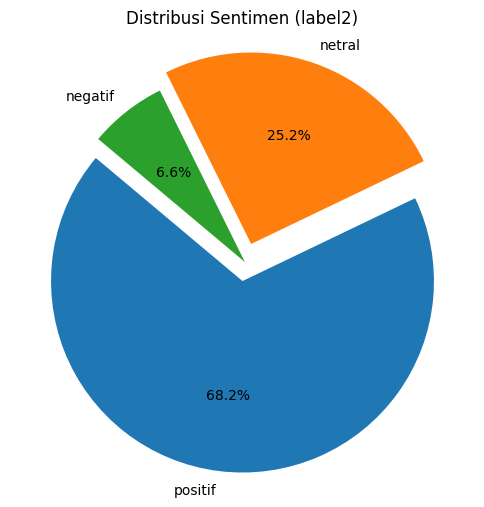

In [51]:
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()

colors = ['#2ecc71', '#f1c40f', '#e74c3c']

plt.figure(figsize=(6,6))
explode = (0.1, 0.1, 0)
plt.pie(label_counts, labels=label_counts.index, explode = explode, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Sentimen (label2)')
plt.axis('equal')
plt.show()


# TF-IDF

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [140]:
docs = df['content_stemmed_text']

tfidf_vect = TfidfVectorizer()
X_tfidf    = tfidf_vect.fit_transform(docs)

print("TF–IDF matrix shape:", X_tfidf.shape)

TF–IDF matrix shape: (2940, 3169)


# Dataset Splitting and SMOTE

In [141]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [142]:
y = df['label']

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Before SMOTE:\n", y_train.value_counts())

Before SMOTE:
 label
positif    1605
netral      593
negatif     154
Name: count, dtype: int64


In [143]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_tfidf, y_train)

print("After SMOTE:\n", pd.Series(y_train_res).value_counts())

After SMOTE:
 label
positif    1605
netral     1605
negatif    1605
Name: count, dtype: int64


# Hyperparameter Tuning

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [145]:
C_grid   = [0.01, 0.1, 1, 10, 100]
cv_scores = {}

for C in C_grid:
    clf = LogisticRegression(
        C=C,
        penalty='l2',
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear',
        random_state=42
    )
    scores = cross_val_score(
        clf,
        X_train_res,
        y_train_res,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    cv_scores[C] = scores.mean()
    print(f"C={C:>5} → CV accuracy = {scores.mean():.4f}")

best_C = max(cv_scores, key=cv_scores.get)
print(f"\nBest C: {best_C} with CV accuracy = {cv_scores[best_C]:.4f}")

C= 0.01 → CV accuracy = 0.8079
C=  0.1 → CV accuracy = 0.8461
C=    1 → CV accuracy = 0.9136
C=   10 → CV accuracy = 0.9468
C=  100 → CV accuracy = 0.9526

Best C: 100 with CV accuracy = 0.9526


# Modelling and Evaluation

In [146]:
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    classification_report, confusion_matrix
)

In [147]:
final_clf = LogisticRegression(
    C=best_C,
    penalty='l2',
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear',
    random_state=42
)
final_clf.fit(X_train_res, y_train_res)

y_pred = final_clf.predict(X_test_tfidf)

In [148]:
print("Accuracy:" ,accuracy_score(y_test,y_pred))
print("Precision:" ,precision_score(y_test,y_pred, average="macro", zero_division=0 ))
print("Recall:" ,recall_score(y_test,y_pred, average="macro", zero_division=0 ))
print("f1_score:" ,f1_score(y_test,y_pred, average="macro", zero_division=0 ))

print(f'confusion matrix:\n {confusion_matrix(y_test, y_pred)}')
print('==================================\n')
print(classification_report(y_test, y_pred, zero_division=0 ))

Accuracy: 0.858843537414966
Precision: 0.77255802728052
Recall: 0.716597568218516
f1_score: 0.7332543830094677
confusion matrix:
 [[ 16  15   8]
 [  6 122  20]
 [  2  32 367]]

              precision    recall  f1-score   support

     negatif       0.67      0.41      0.51        39
      netral       0.72      0.82      0.77       148
     positif       0.93      0.92      0.92       401

    accuracy                           0.86       588
   macro avg       0.77      0.72      0.73       588
weighted avg       0.86      0.86      0.86       588



# Saving Model

In [156]:
import joblib

In [ ]:
joblib.dump(tfidf_vect, 'vectorizer.joblib')
joblib.dump(model, 'model.joblib')